In [ ]:
# Run if using on google collab, change path accordingly
from google.colab import drive # type: ignore
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/[02] School/[01] University/[02] Bachelor\'s Year 2/[02] Spring Semester/[04] Machine Learning/Colab Notebooks/ML - LGI/mlproj/'

In [2]:
# run if running locally
path = ''

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import multiprocessing
import sompy
from sompy.sompy import SOMFactory

cpuc = multiprocessing.cpu_count()-1

#setting seaborn visual style in plt
sns.set_theme()

# Integration & Exploration

In [4]:
dataDF: pd.DataFrame = pd.read_excel(path + 'data/Descriptive_Data.xlsx')
print(f"Duplicaded: {dataDF.duplicated().sum()}\nMissing: {dataDF.isna().sum().sum()}\nNon-Registered (empty): {(dataDF["Registered"] != "Yes").sum()}")

Duplicaded: 1548
Missing: 12475
Non-Registered (empty): 100


In [5]:
# import the data and drop remove useless stuff
dataDF: pd.DataFrame = dataDF.set_index('Userid')
dfSuccess: pd.DataFrame = pd.read_excel(path+'data/Descriptive_Data.xlsx',sheet_name=2)
dfSuccess = dfSuccess.set_index('Userid')
dataDF = dataDF.join(dfSuccess, 'Userid')
dataDF = dataDF.drop('Observations', axis=1).drop_duplicates()
dataDF = dataDF[dataDF['Registered'] == 'Yes']
dataDF = dataDF.drop('Registered', axis=1)

In [6]:
metricFeatures: list[str] = ['Application order','Previous qualification score','Entry score','Age at enrollment','N units credited 1st period',
       'N units taken 1st period', 'N scored units 1st period',
       'N units approved 1st period', 'Average grade 1st period',
       'N unscored units 1st period', 'N units credited 2nd period',
       'N units taken 2nd period', 'N scored units 2nd period',
       'N units approved 2nd period', 'Average grade 2nd period',
       'N unscored units 2nd period','Social Popularity']
categoricalFeatures: list[str] =  ['Application mode','Marital status','Course','Previous qualification','Nationality','Mother\'s qualification',
       'Father\'s qualification','Mother\'s occupation','Father\'s occupation']
boolFeatures: list[str] = ['Morning shift participation','Displaced','Special needs','Debtor','Regularized Fees','Gender_Male','External Funding','International']

academicFeatures: list[str] = ['Previous qualification score','Entry score','N units taken 1st period', 'N scored units 1st period',
       'N units approved 1st period', 'Average grade 1st period',
       'N unscored units 1st period', 'N units credited 2nd period',
       'N units taken 2nd period', 'N scored units 2nd period',
       'N units approved 2nd period', 'Average grade 2nd period',
       'N unscored units 2nd period']
demographicFeatures: list[str] = ['Age at enrollment','Marital status','Course','Previous qualification','Nationality','Mother\'s qualification',
       'Father\'s qualification','Mother\'s occupation','Father\'s occupation','Special needs','International','Debtor','Regularized Fees','Gender_Male']

In [ ]:
dataDF[metricFeatures].describe()

In [ ]:
for variable in categoricalFeatures:
  print(dataDF[variable].value_counts())

In [ ]:
for i, col in enumerate(metricFeatures):
  plt.figure(i)
  sns.boxplot(x=col, data=dataDF)

In [ ]:
# mn.matrix(data)

In [ ]:
# percentage of empty values in a column
round(dataDF.isnull().sum() / dataDF.shape[0] * 100.00,2)

# Preprocessing

In [7]:
def fillNa(data: pd.DataFrame) -> pd.DataFrame:
    """Fill missing values

    Args:
        data (`pd.DataFrame`): Dataframe to be treated

    Returns:
        `pd.DataFrame`: Treated dataframe
    """    

    # on all of these features, if a value were to be different than 0, then it would not be missing, eg units approved, if the student approved, the value wouldn't be missing
    ifNaThen0: tuple[str,...] = (
        "N units credited 1st period",
        "N unscored units 1st period",
        "N scored units 1st period",
        "N units credited 2nd period",
        "N unscored units 2nd period",
        "N scored units 2nd period"
    )

    # these features are filled differently, basically incoherence checking, but filling the Na on 'N units approved 1st/2nd period' is needed beforehand, more info below
    checkAfterVars: list[list[str]] = [
        ["N units taken 1st period", "N scored units 1st period"],
        ["N units taken 2nd period", "N scored units 2nd period"]
    ]

    for var in metricFeatures:
        if var == (checkAfterVars[0][0] or checkAfterVars[1][0]): 
            continue # skip current iteration
        if var in ifNaThen0:
            data[var] = data[var].fillna(0) # fill the ifNaThen0 vars with well, 0s
        else:    
            data[var] = data[var].fillna(data[var].median()) # fill everything else with the median of the values of the feature

    # here we use the n units taken features we skipped earlier, a student has to have taken at least the same number of courses as the number of courses they passed
    for varList in checkAfterVars:
        # search for Na values on N units taken and replace by the equivalent value on N units approved
        data.loc[data[varList[0]].isna(), varList[0]] = data[varList[1]]
        # search for values on N units taken that are smaller than the equivalent on N units approved, replace by the equivalent value on N units approved
        data.loc[data[varList[0]] < data[varList[1]], varList[0]] = data[varList[1]]

    for var in boolFeatures:
        if var == "Regularized Fees":
            data[var] = data[var].fillna(1) # if nothing is said about the fees, we can assume they have been paid
        else:
            data[var] = data[var].fillna(0) # here is like the ifNaThen0 situation, if the values were to not be 0, they would have been declared

    return data

In [8]:
def removeOutliers(data: pd.DataFrame) -> pd.DataFrame:
    """Removes outliers and fixes any negative number incoherences on the selected variables from the dataframe

    Args:
        data (`pd.DataFrame`): Dataframe to be treated

    Returns:
        `pd.DataFrame`: Treated dataframe
    """    

    toBeTreated: dict[str, dict[str, float | None]] = {
        "Application order": {"lower": 0, "upper": None},
        "Previous qualification score": {"lower": 0, "upper": None},
        "Entry score": {"lower": 0, "upper": None},
        "Age at enrollment": {"lower": 0, "upper": None},
        "N units credited 1st period": {"lower": 0, "upper": 15},
        "N units taken 1st period": {"lower": 0, "upper": 20},
        "N scored units 1st period": {"lower": 0, "upper": 25},
        "N units approved 1st period": {"lower": 0, "upper": 20},
        "Average grade 1st period": {"lower": 0, "upper": None},
        "N unscored units 1st period": {"lower": 0, "upper": None},
        "N units credited 2nd period": {"lower": 0, "upper": 14},
        "N units taken 2nd period": {"lower": 0, "upper": 15},
        "N scored units 2nd period": {"lower": 0, "upper": 25},
        "N units approved 2nd period": {"lower": 0, "upper": 15},
        "Average grade 2nd period": {"lower": 0, "upper": None},
        "N unscored units 2nd period": {"lower": 0, "upper": None},
        "Social Popularity": {"lower": 0, "upper": 100},
    }
    
    for var in toBeTreated:
        if toBeTreated[var]["lower"] != None:
            toRemove: list = list(data.loc[data[var] < toBeTreated[var]["lower"], var].index)
        if toBeTreated[var]["upper"] != None:
            toRemove.extend(list(data.loc[data[var] > toBeTreated[var]["upper"], var].index))
        data.drop(toRemove, axis=0, inplace=True)

    return data

In [9]:
def groupValues(data: pd.DataFrame) -> pd.DataFrame:
    """replace values on columns that have lots of different values that can be grouped together to reduce the total number of dummies created after

    Args:
        data (`pd.DataFrame`): Dataframe to be treated

    Returns:
        `pd.DataFrame`: Treated dataframe
    """    
    
    for col in ["Mother's qualification",  "Father's qualification", "Previous qualification"]:
        data.replace(regex={col: {r"(?i)^no school.*$": '0',
                            r"(?i)^[0-4][a-z]{2} grade.*$": '1', 
                            r"(?i)^[5-9]th grade.*$": '2', 
                            r"(?i)^1[0-2]th grade.*$": '3', 
                            r"(?i)^incomplete bachelor.*$": '4', 
                            r"(?i)^bachelor degree.*$": '5',
                            r"(?i)^post-grad.*$": '6',
                            r"(?i)^master degree.*$": '7',
                            r"(?i)^phd.*$": '8',}}, inplace=True)
    
    for col in ["Mother's occupation", "Father's occupation"]:
        data.replace(to_replace={col: ["Superior-level Professional", "Intermediate-level Professional", "Politician/CEO", "Teacher", "Information Technology Specialist"]}, value="Professional Fields", inplace=True)
        data.replace(to_replace={col: ["Skilled construction workers", "Assembly Worker", "Factory worker", "Lab Technocian"]}, value="Technical and Skilled Trades", inplace=True)
        data.replace(to_replace={col: ["Administrative Staff", "Office worker", "Accounting operator"]}, value="White collar Jobs", inplace=True)
        data.replace(to_replace={col: ["Restaurant worker", "Personal care worker", "Seller", "Cleaning worker"]}, value="Service Industry", inplace=True)
        data.replace(to_replace={col: ["Private Security", "Armed Forces"]}, value="Security and Armed Forces", inplace=True)
        data.replace(to_replace={col: ["Unskilled Worker", "Other", "Student", "Artist"]}, value="Recreational or unskilled", inplace=True)
        data.replace(to_replace={col: ["Engineer", "Scientist", "Health professional"]}, value="STEM Jobs", inplace=True)

    data.replace(to_replace={"Marital status": { 
        'single':'alone',
        'divorced':'alone',
        'legally separated':'alone',
        'widower':'alone',
        'married':'together',
        'facto union':'together'
    }}, inplace=True)
                                        
    return data

In [10]:
def getDummies(data: pd.DataFrame) -> pd.DataFrame:
    """get dummies

    Args:
        train (`pd.DataFrame`): Train dataframe to be treated

    Returns:
        `pd.DataFrame` : treated dataframe
    """    
    
    data = pd.get_dummies(data=data, prefix_sep="-", dummy_na=True, drop_first=False)

    return data

In [11]:
def scaleData(data: pd.DataFrame) -> pd.DataFrame:
    """Tranforms the values in the dataframe to fit in a scale of 0 to 1

    Args:
        train (pd.DataFrame): Unscaled train dataframe

    Returns:
        pd.DataFrame: Scaled dataframe
    """    

    scaler = MinMaxScaler()
    scaler.fit(data)

    data = pd.DataFrame(scaler.transform(data), columns = data.columns, index = data.index)

    return data

In [12]:
def encodeSuccess(successData: pd.DataFrame) -> pd.DataFrame:
    """Replace string values on success by integers

    Args:
        successData (pd.DataFrame): Untreated dataframe 

    Returns:
        pd.DataFrame: Treated dataframe
    """    
    successData.replace({'Success': {"Gave up": 0, "Holding on": 1, "Succeeded": 2}}, inplace=True)

    return successData

In [13]:
def prepData(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Runs the preprocessing steps on the dataframe

    Args:
        data (pd.DataFrame): Un-preprocessed data dataframe

    Returns:
        pd.DataFrame: Treated dataframe
    """    
    
    data = encodeSuccess(data)
    data = fillNa(data)
    data = removeOutliers(data)
    data = groupValues(data)
    dataAcademic: pd.DataFrame = data[academicFeatures]
    dataDemographic: pd.DataFrame = data[demographicFeatures]
    dataAcademic = getDummies(dataAcademic)
    dataDemographic = getDummies(dataDemographic)
    dataAcademic = scaleData(dataAcademic)
    dataDemographic = scaleData(dataDemographic)
    data = getDummies(data)
    data = scaleData(data)

    return data, dataAcademic, dataDemographic

# Feature Selection

In [14]:
def pairPlots(data: pd.DataFrame,fileName: str) -> None:
    sns.pairplot(data.sample(1000)).savefig(f"./output/{fileName}.png")

# Clustering

In [15]:
def getSom(data) -> tuple[sompy.sompy.SOM, int, int, np.float32]:
    """_summary_

    Args:
        data (_type_): _description_

    Returns:
        tuple[sompy.sompy.SOM, int, int, np.float32]: _description_
    """    
    df_som = np.float32(data.values)
    rows = 25
    cols = 25
    mapsize: list[int] = [rows, cols]

    som: sompy.sompy.SOM = SOMFactory().build(df_som, mapsize, mask=None,
                            mapshape='planar', # 2Dimensions
                            lattice='rect', # topology: 'rect' or 'hexa'
                            normalization='var', # standardize the variables
                            initialization='pca', # initialization of the weights: 'pca' or 'random'
                            neighborhood='gaussian', # neighborhood function: 'gaussian' or 'bubble'
                            training='batch') # training mode: 'seq' or 'batch'
    
    return som,rows,cols,df_som

In [31]:
def getGraphs(data: pd.DataFrame, somDetails: tuple[sompy.sompy.SOM, int, int, np.float32]) -> None:
    """_summary_

    Args:
        data (pd.DataFrame): _description_
        somDetails (tuple[sompy.sompy.SOM, int, int, np.float32]): _description_
    """    
    somDetails[0].train(n_job=1, verbose=None, train_rough_len=3, train_finetune_len=5)

    u = sompy.umatrix.UMatrixView(somDetails[1], height=somDetails[2], title='U-matrix', show_axis=True, text_size=8, show_text=True)

    #This is the Umat value
    UMAT  = u.build_u_matrix(somDetails[0], distance=1, row_normalized=False)

    #Here you have Umatrix plus its render
    _, umat = u.show(somDetails[0], distance=1, row_normalized=True, contour=True, blob=False)

    somDetails[0].component_names = data.columns
    comp_planes = sompy.mapview.View2DPacked(somDetails[1], somDetails[2], 'Component Planes', text_size=8)
    comp_planes.show(somDetails[0], what='codebook', which_dim='all', col_sz=8)

In [33]:
def clustering(data: pd.DataFrame, somDetails: tuple[sompy.sompy.SOM, int, int, np.float32], nClusters: int = 4) -> pd.DataFrame:
    """_summary_

    Args:
        data (pd.DataFrame): _description_
        somDetails (tuple[sompy.sompy.SOM, int, int, np.float32]): _description_
        clusters (int, optional): _description_. Defaults to 4.
    """    
    somDetails[0].cluster(n_clusters=nClusters)
    labels = getattr(somDetails[0], 'cluster_labels')
    h = sompy.hitmap.HitMapView(10, 10, 'Hitmap', text_size=8, show_text=True)
    h.show(somDetails[0])
    bmus = somDetails[0].project_data(somDetails[3])
    data['bmu'] = bmus
    data['label'] = labels[data['bmu']]

    clusteringResult: pd.DataFrame = data.groupby(['label']).describe().T

    return clusteringResult

In [27]:
def somWrap(data, getClusters: bool = True, nClusters: int = 4) -> pd.DataFrame | None:
    somDetails: tuple[sompy.sompy.SOM, int, int, np.float32] = getSom(data)
    getGraphs(data, somDetails)
    if getClusters:
        return clustering(data, somDetails, nClusters)

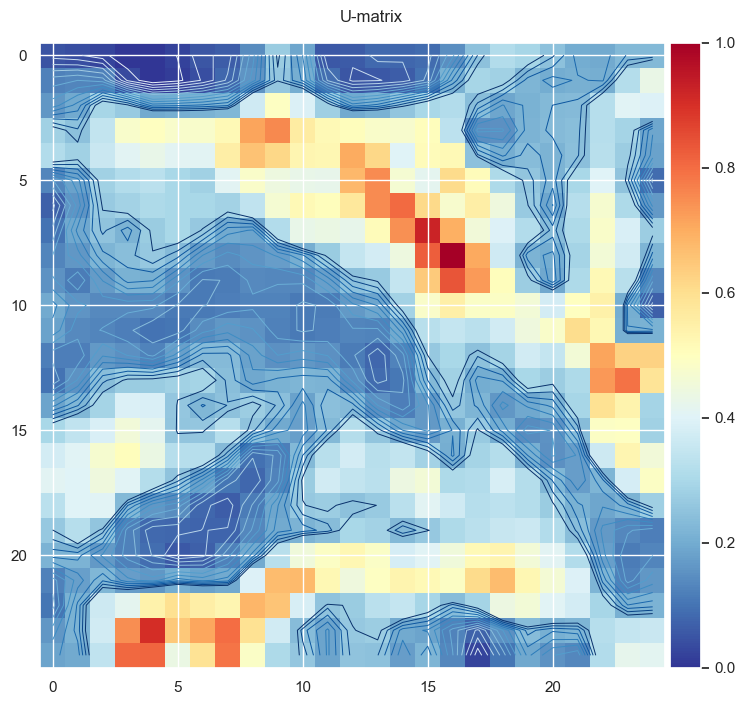

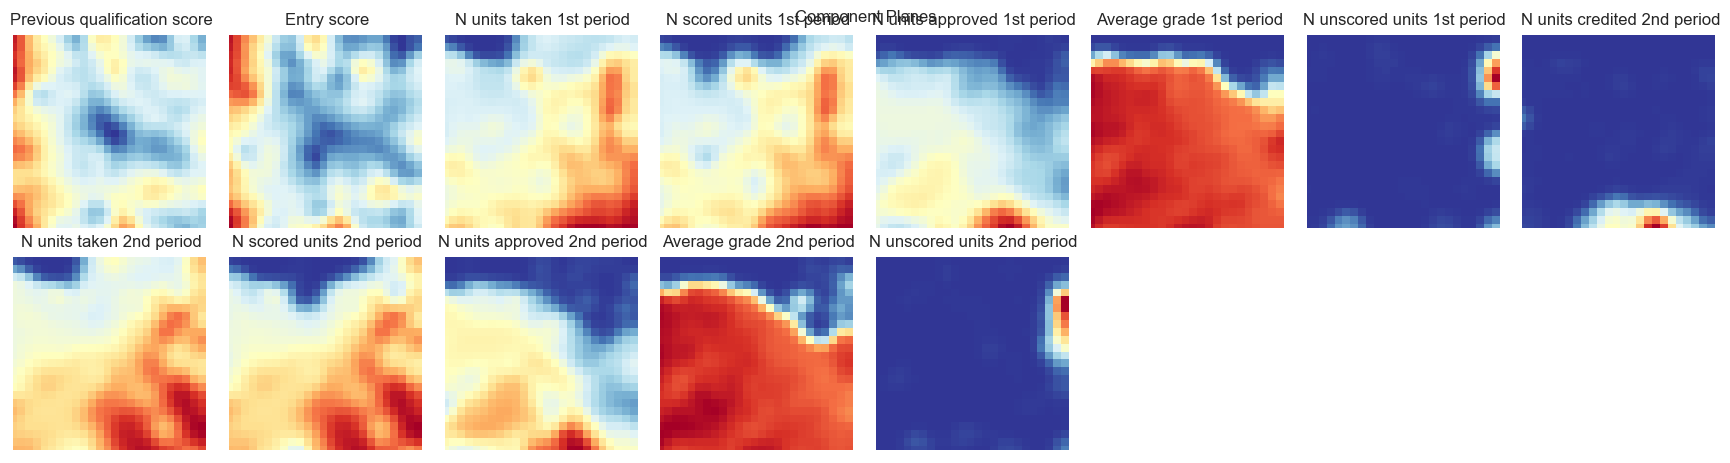

label                                         0           1            2
Previous qualification score count  1161.000000  830.000000  2254.000000
                             mean      0.367683    0.399200     0.410533
                             std       0.124061    0.144444     0.141225
                             min       0.052632    0.010526     0.000000
                             25%       0.273684    0.318421     0.326316
...                                         ...         ...          ...
bmu                          min     218.000000    0.000000    78.000000
                             25%     371.000000   16.000000   232.000000
                             50%     463.000000   42.000000   312.500000
                             75%     543.000000   99.000000   432.000000
                             max     624.000000  224.000000   610.000000

[112 rows x 3 columns]

In [32]:
somWrap(prepData(dataDF)[1],getClusters=True,nClusters=3)

# Model

In [ ]:
def runAll(data: pd.DataFrame, getPairPlot: bool = False, getClusters: bool = True, nClusters: int = 4) -> None:
    """Runs the algorithm

    Args:
        X_train (pd.DataFrame): Raw/Un-preprocessed X_train dataframe
        Y_train (pd.DataFrame): Raw/Un-preprocessed Y_train dataframe
        X_test (pd.DataFrame): Raw/Un-preprocessed X_test dataframe
        split (bool, optional): Whether or not to split the dataframes using train_test_split, used for model assessment. Defaults to False.
    """
    
    dataDF, dataAcademic, dataDemographic = prepData(data)

    if getPairPlot:
        pairPlots(dataAcademic, "AcademicPairPlot")
        pairPlots(dataDemographic, "DemographicPairPlot")

    somWrap(dataAcademic, getClusters, nClusters)
    somWrap(dataDemographic, getClusters, nClusters)

In [ ]:
runAll(dataDF)